# Nordic Optical Telescope images of Ou 5

Images from ALFOSC instrument downloaded from IAC with help of Sergio Armas Pérez <sap@not.iac.es> 2025-07-05

## Imports

In [105]:
from pathlib import Path
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from mes_longslit import regrid_images

In [106]:
sns.set_context("notebook")

## Load headers from all the individual images

In [107]:
datadir = Path.cwd().parent / "data/nordic-images"
_files = sorted(datadir.glob("AL*.fits"))
primary_headers = {
    _.stem: fits.open(_)[0].header
    for _ in _files
}
# list(primary_headers.keys())

## Make table of relevant data from the headers

We want the filters and the exposure time at least

In [108]:
tab = Table(
    [
        {"Name": _name, 
         **{_key: primary_headers[_name][_key] 
            for _key in ["ALFLTNM", "FBFLTNM", "EXPTIME", "DATE-OBS"]}
        }
        for _name in primary_headers
    ]
)
tab

<Table length=13>
   Name       ALFLTNM      FBFLTNM    EXPTIME         DATE-OBS       
  str10        str13        str12     float64          str23         
---------- ------------- ------------ ------- -----------------------
ALwj290115 i_int 797_157         Open   120.0 2013-10-29T19:27:35.209
ALwj290116          Open         Open    60.0 2013-10-29T19:30:31.195
ALwj290117 i_int 797_157         Open    60.0 2013-10-29T19:33:02.715
ALwj290240 i_int 797_157         Open   120.0 2013-10-30T02:31:07.698
ALwj290241 i_int 797_157         Open    60.0 2013-10-30T02:33:49.828
ALwk070080          Open [OIII] 501_3   900.0 2013-11-07T21:41:34.675
ALwk070081          Open [OIII] 501_3   900.0 2013-11-07T21:57:09.752
ALwk070097          Open  Halp 658_18   900.0 2013-11-07T23:21:52.391
ALwk070098          Open  Halp 658_18   900.0 2013-11-07T23:37:27.275
ALze250091  V_Bes 530_80         Open    20.0 2016-05-26T02:01:39.209
ALze250092          Open   HeII 469_3  1200.0 2016-05-26T02:03:24.168
ALze250093          Open   HeII 469_3  1200.0 2016-05-26T02:23:48.809
ALze250094          Open   HeII 469_3  1200.0 2016-05-26T02:44:13.423

So the continuum images have the ALFLTNM and the line images have the FBFLTNM

## Select the frames for each emission line

In [109]:
emline_frame_names = {
    "ha": ["ALwk070097", "ALwk070098"],
    "oiii": ["ALwk070080", "ALwk070081", "../spm-images/imagen-oiii-ardec2"],
    "heii": ["ALze250092", "ALze250093", "ALze250094"], 
    "cont": ["ALwj290115", "ALwj290117"],
}

In [110]:
hdus = {
    _line: [
        fits.open(datadir / (_name + ".fits"))[0]
        if "spm" in _name else
        fits.open(datadir / (_name + ".fits"))[1]
        for _name in _names
    ] for _line, _names in emline_frame_names.items()
}

In [111]:
hdus

{'ha': [<astropy.io.fits.hdu.image.ImageHDU at 0x35e316650>,
 'oiii': [<astropy.io.fits.hdu.image.ImageHDU at 0x35dbe8a90>,
 'heii': [<astropy.io.fits.hdu.image.ImageHDU at 0x35dbea990>,
 'cont': [<astropy.io.fits.hdu.image.ImageHDU at 0x35e0bd850>,
  <astropy.io.fits.hdu.image.ImageHDU at 0x35dbe93d0>]}

## Reproject all frames to a common grid

### Look at an example full frame

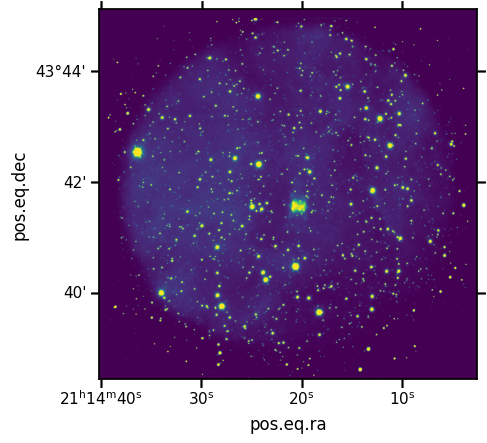

In [112]:
hdu = hdus["ha"][0]
w = WCS(hdu.header)
fig, ax = plt.subplots(subplot_kw=dict(projection=w))
ax.imshow(hdu.data, origin="lower", vmin=11000, vmax=13000)

Here we see the PN surrounded by diffuse emission from the foreground H II region Sh 2-119

In [113]:
bias = np.median(hdu.data[:100, :100])
bias

10016.0

### Reference coordinate for the PN from Simbad. 

Hopefully, this is the position of the central star

In [114]:
c0 = SkyCoord.from_name("PN Ou 5")
c0.ra.to_string(u.hour), c0.dec.to_string(u.deg)

('21h14m20.03539402s', '43d41m36.04832234s')

### Zoom in on the PN

In [115]:
w.world_to_pixel(c0)

(array(1147.30186152), array(991.37403499))

Pixel size

In [116]:
3600 * w.wcs.cd[1, 1]

0.1903094997031854

So that is about 0.2 arcsec. Make a window of 80 arcsec square, as I did previously in 01-01-median-image notebook

In [117]:
j0, i0 = w.world_to_array_index(c0)

In [118]:
zoom_size = 40
zoom_xslice = slice(i0 - 5 * zoom_size, i0 + 5 * zoom_size)
zoom_yslice = slice(j0 - 5 * zoom_size, j0 + 5 * zoom_size)
zoom_xslice, zoom_yslice

(slice(947, 1347, None), slice(791, 1191, None))

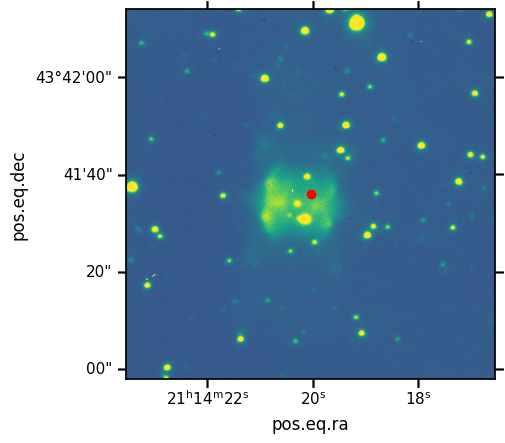

In [119]:
fig, ax = plt.subplots(subplot_kw=dict(projection=w))
ax.imshow(hdu.data - bias, origin="lower", vmin=0, vmax=4000)
ax.set_xlim(zoom_xslice.start, zoom_xslice.stop)
ax.set_ylim(zoom_yslice.start, zoom_yslice.stop)
ax.plot_coord(c0, "o", color="r")

CSPN is not centered. I have measured its pixel position in DS9

In [120]:
istar, jstar = 1133.454, 981.86892
istar - i0, jstar - j0

(-13.54600000000005, -9.131079999999997)

### Fix the alignment

So one way of fixing it is to set crpix to [istar, jstar] and crval to c0

In [121]:
wfix = w.copy()
wfix.wcs.crpix = istar, jstar
wfix.wcs.crval = c0.ra.deg, c0.dec.deg

Recalculate the zoom window around the corrected position

In [122]:
j0, i0 = wfix.world_to_array_index(c0)
zoom_size = 35
zoom_xslice = slice(i0 - 5 * zoom_size, i0 + 5 * zoom_size)
zoom_yslice = slice(j0 - 5 * zoom_size, j0 + 5 * zoom_size)
zoom_xslice, zoom_yslice

(slice(957, 1307, None), slice(806, 1156, None))

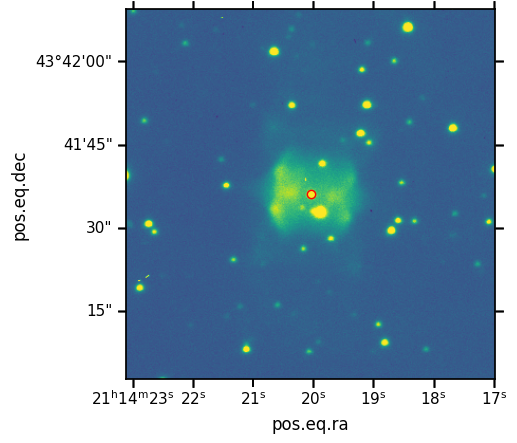

In [123]:
fig, ax = plt.subplots(subplot_kw=dict(projection=wfix))
ax.imshow(hdu.data - bias, origin="lower", vmin=0, vmax=4000)
ax.set_xlim(zoom_xslice.start, zoom_xslice.stop)
ax.set_ylim(zoom_yslice.start, zoom_yslice.stop)
ax.plot_coord(c0, "o", color="r", fillstyle="none")

### Do the reprojection of all the images

We will use my `mes_longslit.regrid_images()` function, but first we need to measure the pixel position of the central star on all the images. 

I do this by hand in DS9 and record the results in the following dict:

In [124]:
crpix_CSPN = {
    "ALwk070097": (1133.454, 981.86892), 
    "ALwk070098": (1054.2045, 982.06465),
    "ALwk070080": (1096.16, 980.96),
    "ALwk070081": (1017.3492, 981.18918),
    "ALze250092": (1062.6922, 1017.6262),
    "ALze250093": (1061.9223, 1017.9001),
    "ALze250094": (1061.5267, 1018.005),
    "ALwj290115": (1060.9787, 987.40088),
    "ALwj290117": (1061.2165, 987.26927),
    "../spm-images/imagen-oiii-ardec2": (260.5, 260.5),
}

Fixup all the alignments, writing back into the HDU headers. And subtract bias while we are at it.

Also subtract the hii region backgound. We can use a percentile of the full image to get a suitable BG level, but this may need to be tuned by line

*Update 2025-07-12* We adjust the plate scale of the heii images by 2%, so that the stars line up better.

In [125]:
bgcentiles = {
    "ha": 75,
    "oiii": 75,
    "heii": 85,
    "cont": 85,
}

for _line in hdus.keys():
    for _hdu, _name in zip(hdus[_line], emline_frame_names[_line]):
        w = WCS(_hdu.header)
        w.wcs.crpix = crpix_CSPN[_name]
        w.wcs.crval = c0.ra.deg, c0.dec.deg
        if _line == "heii":
            w.wcs.cd *= 1.02
        _hdu.header.update(w.to_header())
        _hdu.data = _hdu.data.astype("float")
        bgcentile = 50 if "spm" in _name else bgcentiles[_line]
        bg = np.percentile(_hdu.data, bgcentile)
        _hdu.data -= bg
        print(_line, bg)

ha 11208.0
ha 11216.0
oiii 10121.0
oiii 10134.0
oiii 11.433349609375


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


heii 13334.0
heii 13225.0
heii 13091.0
cont 11994.0
cont 10824.0


This works mostly fine, but it does mean that the bg-subtracted image in Ha goes negative to the E of the PN, since the H II region brightness has a minimum there

In [126]:
fits.HDUList([hdu])

In [127]:
new_hdus = {
    _line: [
        regrid_images(
            fits.HDUList([_hdu]),
            center=c0, 
            pixscale=0.2 * u.arcsec,
            shape=(400, 400),
        )[0]
        for _hdu in hdus[_line]
    ]
    for _line in hdus.keys()
}

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [128]:
new_hdus

{'ha': [<astropy.io.fits.hdu.image.ImageHDU at 0x35df7fad0>,
 'oiii': [<astropy.io.fits.hdu.image.ImageHDU at 0x35dd18510>,
 'heii': [<astropy.io.fits.hdu.image.ImageHDU at 0x35dff7dd0>,
 'cont': [<astropy.io.fits.hdu.image.ImageHDU at 0x35e514810>,
  <astropy.io.fits.hdu.image.ImageHDU at 0x35de92850>]}

### Check that they came out ok

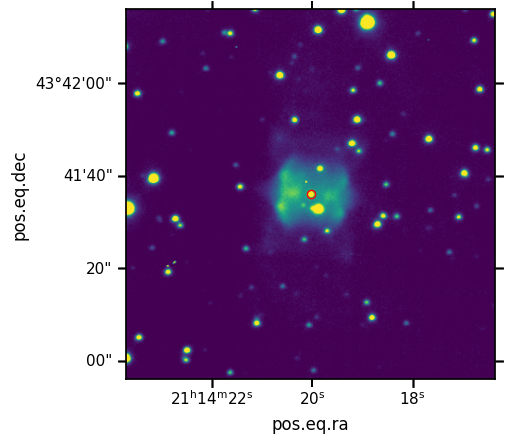

In [129]:
hdu = new_hdus["ha"][0]
w = WCS(hdu.header)
fig, ax = plt.subplots(subplot_kw=dict(projection=w))
ax.imshow(hdu.data, origin="lower", vmin=0, vmax=3000)
ax.plot_coord(c0, "o", color="r", fillstyle="none")

### Save the regridded aligned images

In [130]:
for _line in new_hdus.keys():
    for _i, _hdu in enumerate(new_hdus[_line]):
        _hdu.writeto(
            datadir / f"nordic-ou5-{_line}-{_i:02d}-regrid.fits",
            overwrite=True,
        )

## Co-add all exposures of each line

This is most useful for He II, which has three images. We can take the median and use outliers to make a mask for eliminating CR by setting to NaN, then use nanmean to combine the 3 images and get best SNR. 

### Co-add He II frames

In [131]:
heii_stack = np.stack(
    [_hdu.data for _hdu in new_hdus["heii"]]
)
heii_stack.shape

(3, 400, 400)

In [132]:
heii_median = np.median(heii_stack, axis=0, keepdims=True)
heii_std = np.std(heii_stack, axis=0, keepdims=True)
heii_std_med = np.median(heii_std)
heii_std_med, np.min(heii_std), np.max(heii_std)

(63.07869523640739, 0.04876967583656262, 36766.015047927925)

So we do some sort of fake sigma clipping across the three frames for each pixel

Question is whether to use a single sigma for all, or to adapt it. Here is image of the sigma

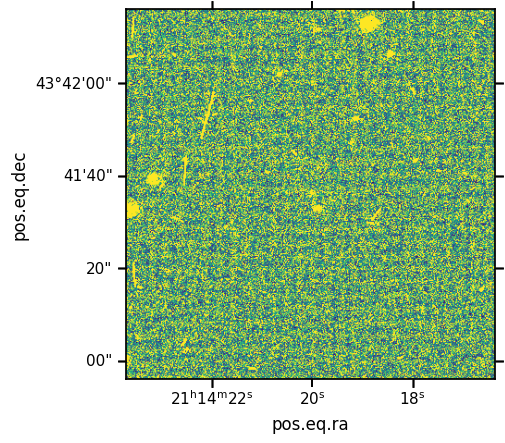

In [133]:
fig, ax = plt.subplots(subplot_kw=dict(projection=w))
ax.imshow(heii_std[0], origin="lower", vmin=0, vmax=100)

I have experimented with various values and 1.5 sigma seems the best threshold. More than 2.0 gets zero pixels, and much less gives too many hits. I also put a condition on the brightness, so we do not get too many false positives

In [134]:
badmask = (
    (np.abs(heii_stack - heii_median) > 1.5 * heii_std) 
    & (heii_stack > 800)
)
np.sum(badmask)

1886

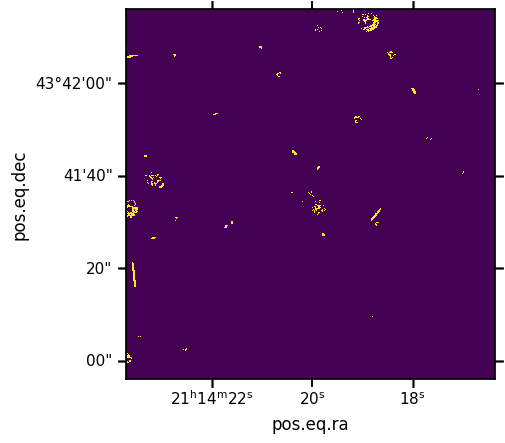

In [135]:
fig, ax = plt.subplots(subplot_kw=dict(projection=w))
ax.imshow(badmask[1], origin="lower", vmin=0, vmax=1, interpolation="none")

In [136]:
heii_stack[badmask] = np.nan

In [137]:
heii_mean = np.nanmean(heii_stack, axis=0)

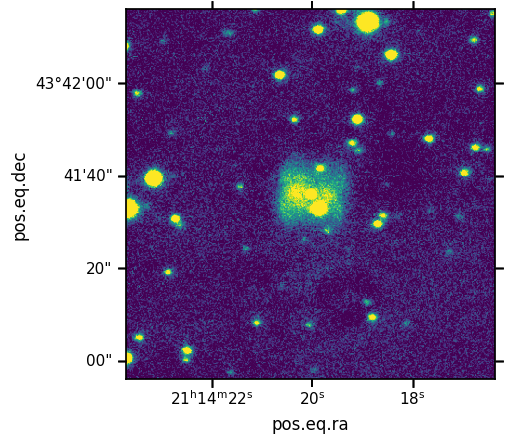

In [138]:
fig, ax = plt.subplots(subplot_kw=dict(projection=w))
ax.imshow(heii_mean, origin="lower", vmin=0, vmax=600, interpolation="none")

In [139]:
heii_hdu = fits.PrimaryHDU(
    header=new_hdus["heii"][0].header,
    data=heii_mean,
)
heii_hdu.writeto(
    datadir / f"nordic-ou5-heii-coadd-regrid.fits",
    overwrite=True,    
)

### Co-add H alpha frames

We only have two frames, but it is still worthwhile combining them

In [140]:
ha_stack = np.stack(
    [_hdu.data for _hdu in new_hdus["ha"]]
)
ha_stack.shape

(2, 400, 400)

In [141]:
from scipy import ndimage

In [142]:
ha_median = np.median(ha_stack, axis=0, keepdims=True)
ha_std = np.std(ha_stack, axis=0, keepdims=True)
ha_std_med = np.median(ha_std)
ha_std_med, np.min(ha_std), np.max(ha_std)

(20.990351186952097, 2.9174816978283502e-05, 16934.141517664626)

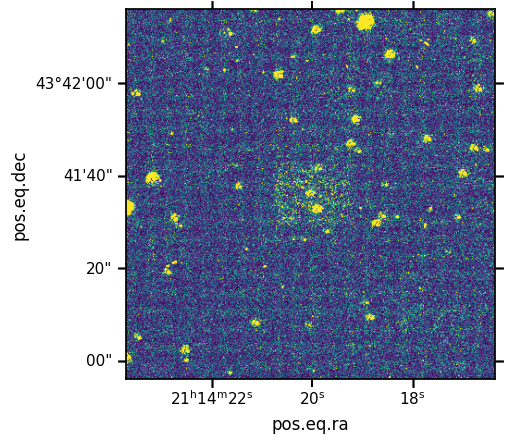

In [143]:
fig, ax = plt.subplots(subplot_kw=dict(projection=w))
ax.imshow(ha_std[0], origin="lower", vmin=0, vmax=100)

Here we have to work harder to get a good mask. As well as the conditions on the brightness and the deviation from the median, we also require the pixel to be at least 3 times brighter than its pair in the other frame.

In [144]:
badmask = (
    (np.abs(ha_stack - ha_median) > 100) 
    & (ha_stack > 100)
    & (ha_stack > 1.2 * np.min(ha_stack, axis=0, keepdims=True))
)
np.sum(badmask)

1121

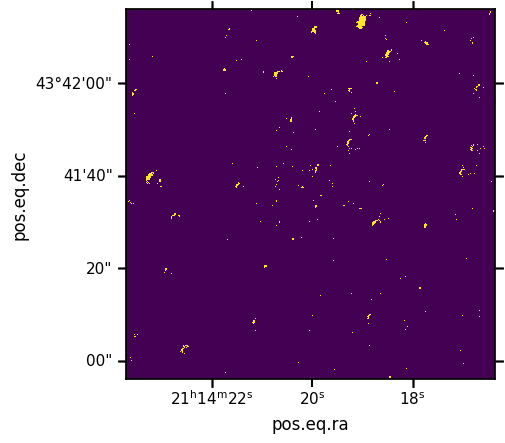

In [145]:
fig, ax = plt.subplots(subplot_kw=dict(projection=w))
ax.imshow(badmask[1], origin="lower", vmin=0, vmax=1, interpolation="none")

In [146]:
ha_stack[badmask] = np.nan

In [147]:
ha_mean = np.nanmean(ha_stack, axis=0)

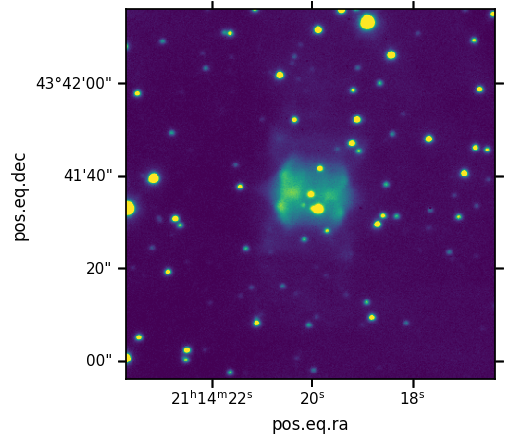

In [148]:
fig, ax = plt.subplots(subplot_kw=dict(projection=w))
ax.imshow(ha_mean, origin="lower", vmin=-100, vmax=3000, interpolation="none")

In [149]:
ha_hdu = fits.PrimaryHDU(
    header=new_hdus["ha"][0].header,
    data=ha_mean,
)
ha_hdu.writeto(
    datadir / f"nordic-ou5-ha-coadd-regrid.fits",
    overwrite=True,    
)

### Oiii frames (nothing to do)

The second Oiii frame is much weaker - maybe affected by cloud. So there is no advantage in combining the two frames.


In [150]:
oiii_hdu = fits.PrimaryHDU(
    header=new_hdus["oiii"][0].header,
    data=new_hdus["oiii"][0].data,
)
oiii_hdu.writeto(
    datadir / f"nordic-ou5-oiii-coadd-regrid.fits",
    overwrite=True,    
)

### Combine SPM and NOT Oiii images

This might give us better s/n for the faint outer parts, although the SPM image has worse seeing

In [151]:
spm_boost = 4.0
oiii_stack = np.stack(
    [new_hdus["oiii"][0].data, spm_boost * new_hdus["oiii"][2].data]
)
oiii_stack.shape

(2, 400, 400)

We need to take into account the different normalizations for the two images, which we account for with the spm_boost

Look at the percentiles:

In [152]:
centiles = [10, 25, 50, 75, 90]
[
    np.percentile(oiii_stack[0], centiles),
    np.percentile(oiii_stack[1], centiles),
]

[array([-20.76618603, -11.10598132,   0.66839831,  16.4542721 ,
         59.31257102]),
 array([-11.59929591,  -5.85048562,   1.37531516,  13.16247965,
         64.40847435])]

That is good enough since we only need the brightnesses to be approximately the same so that we give equal weight to each image (SPM has longer exposure but smaller telescope and worse seeing)

In [153]:
oiii_mean = np.nanmean(oiii_stack, axis=0)

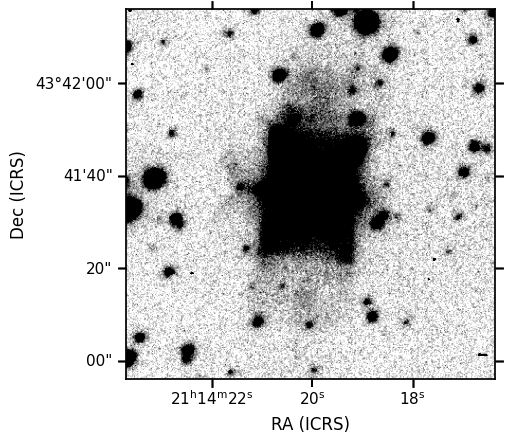

In [154]:
fig, ax = plt.subplots(subplot_kw=dict(projection=w))
ax.imshow(
    oiii_mean, 
    origin="lower", vmin=-10, vmax=50, interpolation="none", 
    cmap="gray_r",
)
ax.set_xlabel("RA (ICRS)")
ax.set_ylabel("Dec (ICRS)")

In [155]:
figfile = "nordic-pn-ou5-deep-oiii-image.pdf"
fig.savefig(figfile, bbox_inches="tight")
fig.savefig(figfile.replace(".pdf", ".jpg"), bbox_inches="tight")

In [156]:
oiii_deep_hdu = fits.PrimaryHDU(
    header=new_hdus["oiii"][0].header,
    data=oiii_mean,
)
oiii_deep_hdu.writeto(
    datadir / f"nordic-spm-ou5-oiii-coadd-regrid.fits",
    overwrite=True,    
)

### Co-add continuum frames 

We have two usable continuum images, but one is a shorter exposure. Add them anyhow

In [157]:
c_stack = np.stack(
    [_hdu.data for _hdu in new_hdus["cont"]]
)
c_stack.shape

(2, 400, 400)

In [158]:
c_sum = np.nansum(c_stack, axis=0)

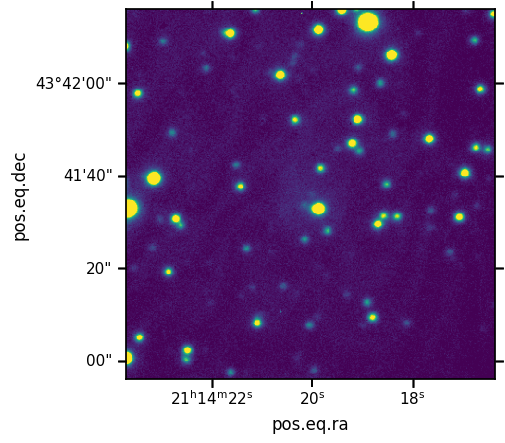

In [159]:
fig, ax = plt.subplots(subplot_kw=dict(projection=w))
ax.imshow(c_sum, origin="lower", vmin=-100, vmax=3000, interpolation="none")

In [160]:
c_hdu = fits.PrimaryHDU(
    header=new_hdus["cont"][0].header,
    data=c_sum,
)
c_hdu.writeto(
    datadir / f"nordic-ou5-cont-coadd-regrid.fits",
    overwrite=True,    
)

## Color images


In [161]:
def rescale(im, vmin, vmax):
    """
    Rescale image to range 0.0->1.0
    """
    return np.where(
        im > vmin,
        np.where(
            im < vmax,
            (im - vmin) / (vmax - vmin),
            1.0,
        ),
        0.0,
    )

In [162]:
rgbim = np.stack(
    [
        rescale(heii_hdu.data, 0, 600),
        rescale(ha_hdu.data, -200, 3000) ** 0.5,
        rescale(oiii_hdu.data, -90, 1500) ** 0.4,
    ],
    axis=-1,
)

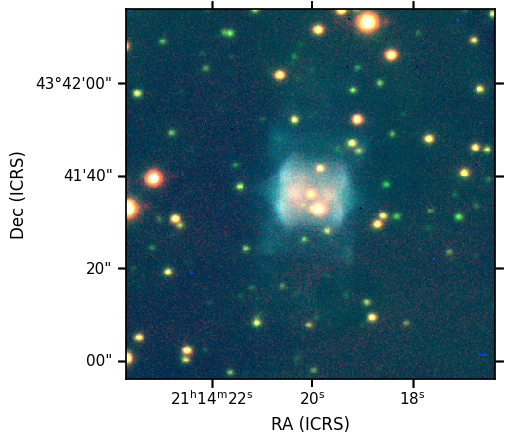

In [163]:
fig, ax = plt.subplots(subplot_kw=dict(projection=w))
ax.imshow(rgbim, origin="lower", interpolation="none")
ax.set_xlabel("RA (ICRS)")
ax.set_ylabel("Dec (ICRS)")

In [164]:
figfile = "nordic-pn-ou5-rgb-image.pdf"
fig.savefig(figfile, bbox_inches="tight")
fig.savefig(figfile.replace(".pdf", ".jpg"), bbox_inches="tight")

### Combine RGB with deep image

Make a mask that includes only the parts that are black in the deep combined SPM+NOT image

In [165]:
bright_mask = oiii_mean > 50

And then make all unmasked portions of the RGB image transparent

In [166]:
rgba_im = np.stack(
    [
        rescale(heii_hdu.data, 0, 600),
        rescale(ha_hdu.data, -200, 3000) ** 0.5,
        rescale(oiii_hdu.data, -90, 1500) ** 0.4,
        np.where(bright_mask, 1.0, 0.0),
    ],
    axis=-1,
)

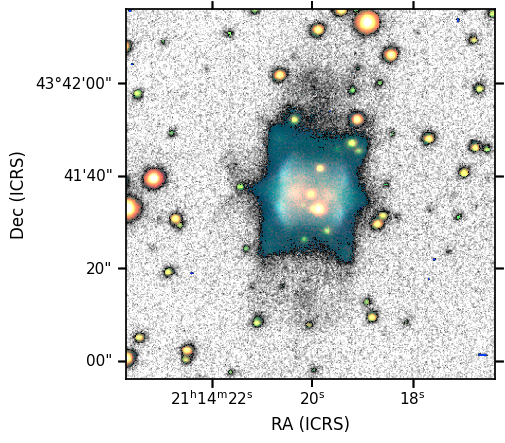

In [167]:
fig, ax = plt.subplots(subplot_kw=dict(projection=w))

ax.imshow(
    oiii_mean, 
    origin="lower", vmin=-10, vmax=50, interpolation="none", 
    cmap="gray_r",
)
ax.imshow(rgba_im, origin="lower", interpolation="none")
ax.set_xlabel("RA (ICRS)")
ax.set_ylabel("Dec (ICRS)")

In [168]:
figfile = "nordic-pn-ou5-deep-rgb-image.pdf"
fig.savefig(figfile, bbox_inches="tight")
fig.savefig(figfile.replace(".pdf", ".jpg"), bbox_inches="tight")

## Remove the stars

Find the stars and remove them from the image

Actually, we will first try it by subtracting the continuum image, although this will only work for one particular color of star. We do it for the brightest one. 

In [169]:
star_peaks = {
    "ha": 23000.0,
    "oiii": 2000.0,
    "heii": 5400.0,
    "cont": 15990.0,
}

In [170]:
ha_csub = ha_hdu.data - 0.8 * c_hdu.data * star_peaks["ha"] / star_peaks["cont"] 
oiii_csub = oiii_hdu.data - 0.8 * c_hdu.data * star_peaks["oiii"] / star_peaks["cont"] 
heii_csub = heii_hdu.data - 0.8 * c_hdu.data * star_peaks["heii"] / star_peaks["cont"] 


In [171]:
rgbim_csub = np.stack(
    [
        rescale(heii_csub, 0, 600),
        rescale(ha_csub, -200, 3000) ** 0.5,
        rescale(oiii_csub, -90, 1500) ** 0.4,
    ],
    axis=-1,
)

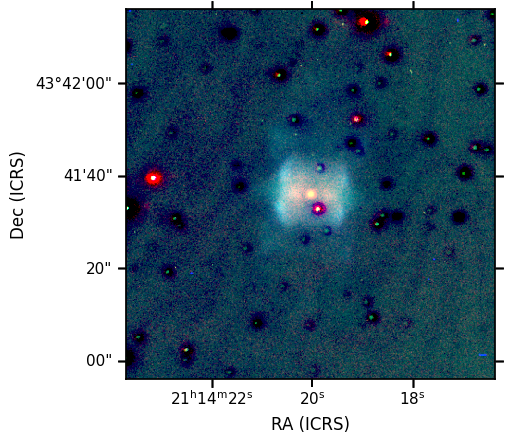

In [172]:
fig, ax = plt.subplots(subplot_kw=dict(projection=w))
ax.imshow(rgbim_csub, origin="lower", interpolation="none")
ax.set_xlabel("RA (ICRS)")
ax.set_ylabel("Dec (ICRS)")

No, that failed spectacularly. 

The seeing seems worse for the continuum images, so we undersubtract core while oversubtracting halo. Also, we introduce a bunch of spurious wormy structure in the background.

### Use a mask and interpolate nans

In [173]:
starmask = c_hdu.data > 800

In [174]:
from astropy.convolution import interpolate_replace_nans, Gaussian2DKernel

In [175]:
kernel = Gaussian2DKernel(x_stddev=3)

In [176]:
ha_fix = interpolate_replace_nans(
    np.where(starmask, np.nan, ha_hdu.data),
    kernel,
)
oiii_fix = interpolate_replace_nans(
    np.where(starmask, np.nan, oiii_hdu.data),
    kernel,
)
heii_fix = interpolate_replace_nans(
    np.where(starmask, np.nan, heii_hdu.data),
    kernel,
)

In [177]:
rgbim_fix = np.stack(
    [
        rescale(heii_fix, 0, 600),
        rescale(ha_fix, -200, 3000) ** 0.5,
        rescale(oiii_fix, -90, 1500) ** 0.4,
    ],
    axis=-1,
)

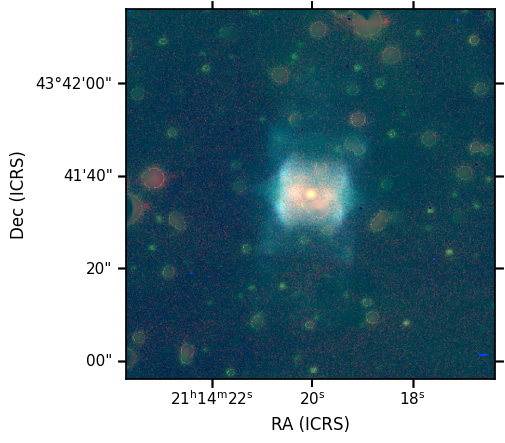

In [178]:
fig, ax = plt.subplots(subplot_kw=dict(projection=w))
ax.imshow(rgbim_fix, origin="lower", interpolation="none")
ax.set_xlabel("RA (ICRS)")
ax.set_ylabel("Dec (ICRS)")

In [179]:
figfile = "nordic-pn-ou5-rgb-image-nostars.pdf"
fig.savefig(figfile, bbox_inches="tight")
fig.savefig(figfile.replace(".pdf", ".jpg"), bbox_inches="tight")

So that is sort of OK, but it still shows artefacts. I do not think it is worth including in the paper

## Reproject onto nebular axis-equator frame



In [180]:
nebframe = c0.skyoffset_frame(rotation=10 * u.deg)

In [181]:
nebframe

<SkyOffsetICRS Frame (rotation=10.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (318.58348081, 43.69334676)>)>

Actually this is very simple. I do not need to use a skyoffset frame. I just need to rotate the CD matrix, but I need to work out whether the rotation should be positive or negative

In [182]:
w

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 318.5834808084 43.693346756204 
CRPIX : 200.5 200.5 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -5.5555555555556e-05 5.5555555555556e-05 
NAXIS : 400  400

Set the rotation angle

In [183]:
theta = 6 * u.deg
cth, sth = np.cos(theta), np.sin(theta)

Make a rotated WCS centered on the CSPN

In [184]:
wrot = WCS(naxis=2)

In [185]:
wrot.wcs.crpix = w.wcs.crpix
wrot.wcs.cdelt = w.wcs.cdelt
wrot.wcs.crval = w.wcs.crval
wrot.wcs.ctype = w.wcs.ctype
wrot.wcs.pc = [[cth, sth], [-sth, cth]]
wrot

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 318.5834808084 43.693346756204 
CRPIX : 200.5 200.5 
PC1_1 PC1_2  : 0.9945218953682733 0.10452846326765347 
PC2_1 PC2_2  : -0.10452846326765347 0.9945218953682733 
CDELT : -5.5555555555556e-05 5.5555555555556e-05 
NAXIS : 0  0

Do the projections

In [186]:
from reproject import reproject_exact

In [187]:
ha_imrot = reproject_exact(
    ha_hdu, wrot, ha_hdu.data.shape, return_footprint=False,
)
heii_imrot = reproject_exact(
    heii_hdu, wrot, heii_hdu.data.shape, return_footprint=False,
)
oiii_imrot = reproject_exact(
    oiii_hdu, wrot, oiii_hdu.data.shape, return_footprint=False,
)

Check the result

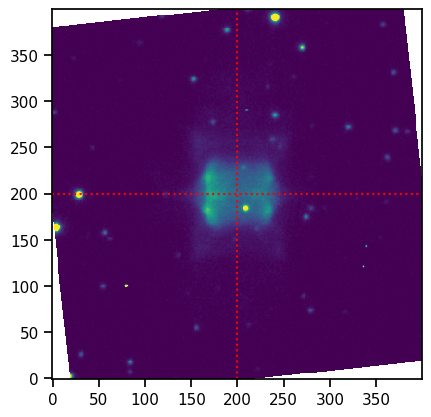

In [188]:
fig, ax = plt.subplots()
ax.imshow(oiii_imrot, origin="lower", interpolation="none", vmin=0, vmax=1500)
ax.axhline(w.wcs.crpix[1] - 1, color="r", ls="dotted")
ax.axvline(w.wcs.crpix[1] - 1, color="r", ls="dotted")


This looks good for a rotation of 6 degrees

Repeat for the no-star images

In [189]:
ha_fixrot = reproject_exact(
    fits.PrimaryHDU(data=ha_fix, header=ha_hdu.header), wrot, ha_hdu.data.shape, return_footprint=False,
)
heii_fixrot = reproject_exact(
    fits.PrimaryHDU(data=heii_fix, header=heii_hdu.header), wrot, heii_hdu.data.shape, return_footprint=False,
)
oiii_fixrot = reproject_exact(
    fits.PrimaryHDU(data=oiii_fix, header=oiii_hdu.header), wrot, oiii_hdu.data.shape, return_footprint=False,
)

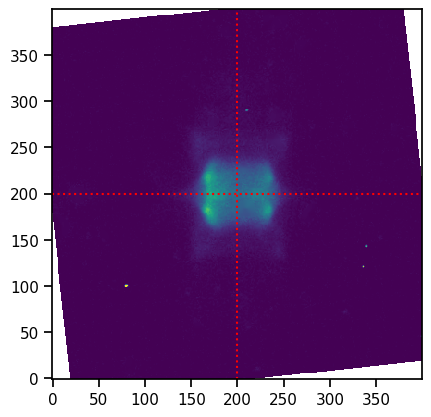

In [190]:
fig, ax = plt.subplots()
ax.imshow(oiii_fixrot, origin="lower", interpolation="none", vmin=0, vmax=1500)
ax.axhline(w.wcs.crpix[1] - 1, color="r", ls="dotted")
ax.axvline(w.wcs.crpix[1] - 1, color="r", ls="dotted")


## Profiles along axis and equator

Maybe use bigger fonts for these figures

In [191]:
sns.set_context("talk")

Set up offset coordinate arrays in arcsec

In [192]:
ny, nx = ha_imrot.shape
j0, i0 = wrot.wcs.crpix
j0 -= 1
i0 -= 1
pixel = 0.2
x = (np.arange(nx) - i0) * pixel
y = (np.arange(ny) - j0) * pixel
X, Y = np.meshgrid(x, y)

Slice windows for simulating slits. I have experimented with different values for `half_width` and it seems that 2 arcsec is the best for the median profiles, especially the equatorial cut, which is the most important

In [193]:
half_width = 2.0
slit_slice = slice(
    int(i0 - half_width / pixel), 
    int(i0 + half_width / pixel) + 1,
)
slit_slice

slice(189, 210, None)

In [194]:
_norm = {"ha": 2500, "oiii": 1000, "heii": 700}
# Use the same order as RGB image to get consistent colors
_imrot = {
    "heii": heii_imrot,
    "ha": ha_imrot, 
    "oiii": oiii_imrot, 
}
_label = {
    "heii": r"He II $\lambda 4686$",
    "ha": r"H$\alpha$ $\lambda 6563$", 
    "oiii": r"[O III] $\lambda 5007$", 
}
_mean = {
    _id: np.mean(_imrot[_id][slit_slice, :], axis=0) / _norm[_id]
    for _id in _imrot
} 
_median = {
    _id: np.median(_imrot[_id][slit_slice, :], axis=0) / _norm[_id]
    for _id in _imrot
} 
_std = {
    _id: np.std(_imrot[_id][slit_slice, :], axis=0) / _norm[_id]
    for _id in _imrot
} 
_q1 = {
    _id: np.percentile(_imrot[_id][slit_slice, :], 25, axis=0) / _norm[_id]
    for _id in _imrot
} 
_p10 = {
    _id: np.percentile(_imrot[_id][slit_slice, :], 10, axis=0) / _norm[_id]
    for _id in _imrot
} 
_q3 = {
    _id: np.percentile(_imrot[_id][slit_slice, :], 75, axis=0) / _norm[_id]
    for _id in _imrot
} 

#### Mean profiles

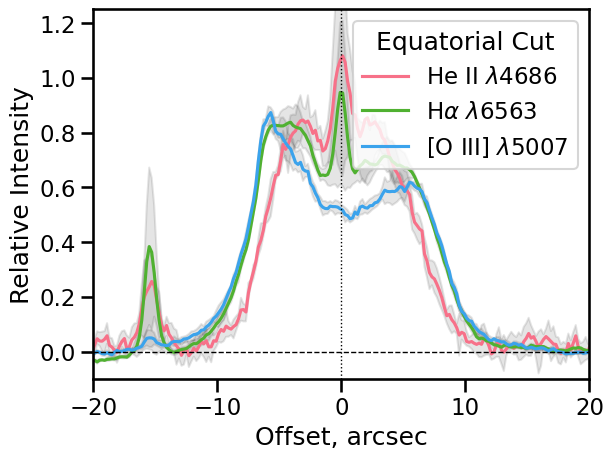

In [195]:
with sns.color_palette("husl", n_colors=3):
    fig, ax = plt.subplots()
    for _id in _imrot:
        line, = ax.plot(x, _mean[_id], label=_label[_id])
        ax.fill_between(
            # x, _mean[_id] - _std[_id], _mean[_id] + _std[_id], 
            x, _q1[_id], _q3[_id],
            alpha=0.1,
            # color=line.get_color(),
            color="k",
        )
    ax.axhline(0.0, color="k", linestyle="dashed", lw=1)
    ax.axvline(0.0, color="k", linestyle="dotted", lw=1)
    
    ax.set_xlim(-20, 20)
    ax.set_ylim(-0.1, 1.25)
    ax.set_xlabel("Offset, arcsec")
    ax.set_ylabel("Relative Intensity")
    ax.legend(title="Equatorial Cut")

In [196]:
figfile = "nordic-pn-ou5-equator-profile.pdf"
fig.savefig(figfile, bbox_inches="tight")
fig.savefig(figfile.replace(".pdf", ".jpg"), bbox_inches="tight")

Repeat for polar profile

In [197]:
_mean_p = {
    _id: np.mean(_imrot[_id][:, slit_slice], axis=1) / _norm[_id]
    for _id in _imrot
} 
_median_p = {
    _id: np.median(_imrot[_id][:, slit_slice], axis=1) / _norm[_id]
    for _id in _imrot
} 
_q1_p = {
    _id: np.percentile(_imrot[_id][:, slit_slice], 25, axis=1) / _norm[_id]
    for _id in _imrot
} 
_p10_p = {
    _id: np.percentile(_imrot[_id][:, slit_slice], 10, axis=1) / _norm[_id]
    for _id in _imrot
} 
_q3_p = {
    _id: np.percentile(_imrot[_id][:, slit_slice], 75, axis=1) / _norm[_id]
    for _id in _imrot
}

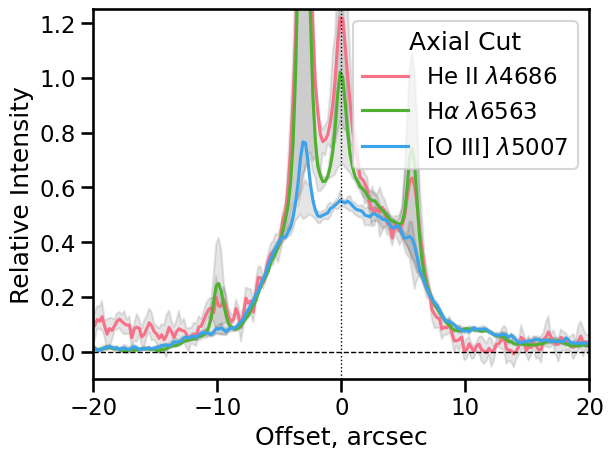

In [198]:
with sns.color_palette("husl", n_colors=3):
    fig, ax = plt.subplots()
    for _id in _imrot:
        line, = ax.plot(x, _mean_p[_id], label=_label[_id])
        ax.fill_between(
            x, _q1_p[_id], _q3_p[_id],
            alpha=0.1,
            color="k",
        )
    ax.axhline(0.0, color="k", linestyle="dashed", lw=1)
    ax.axvline(0.0, color="k", linestyle="dotted", lw=1)
    ax.set_xlim(-20, 20)
    ax.set_ylim(-0.1, 1.25)
    ax.set_xlabel("Offset, arcsec")
    ax.set_ylabel("Relative Intensity")
    ax.legend(title="Axial Cut")

#### Median profiles

Try a version using percentiles to avoid the stars. Also, remove a linear trend from all the profiles to help reduce foreground nebula contamination


In [199]:
from numpy.polynomial import Polynomial
bg = {}
for _id in _imrot:
    # Select BG pixels
    if _id == "heii":
        bgpix = np.abs(np.abs(x) - 22) <= 3
    else:
        bgpix = np.abs(np.abs(x) - 25) <= 5
    p = Polynomial.fit(x[bgpix], _median[_id][bgpix], 1)
    bg[_id] = p(x)


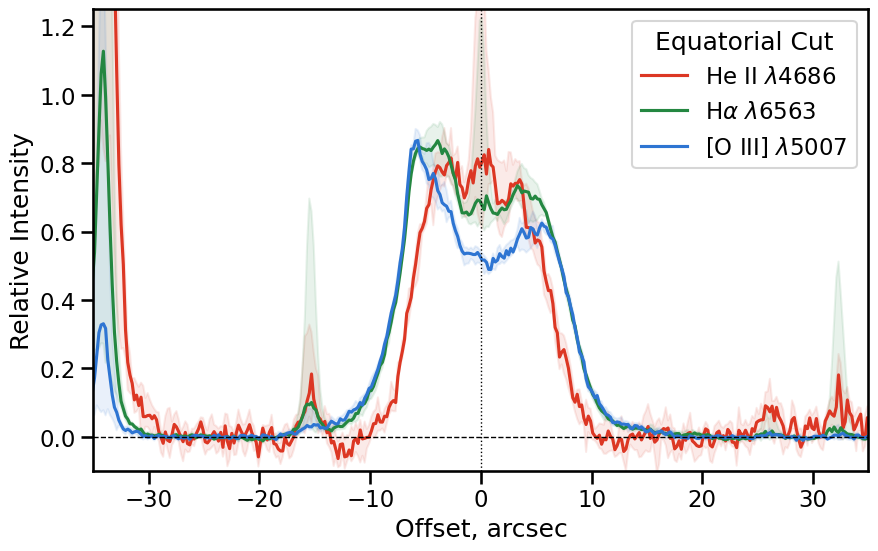

In [209]:
with sns.husl_palette(l=0.5, h=0.04, n_colors=3):
    fig, ax = plt.subplots(figsize=(10, 6))
    for _id in _imrot:
        line, = ax.plot(x, _median[_id] - bg[_id], label=_label[_id])
        ax.fill_between(
            # x, _mean[_id] - _std[_id], _mean[_id] + _std[_id], 
            x, _q1[_id] - bg[_id], _q3[_id] - bg[_id],
            alpha=0.1,
            color=line.get_color(),
            # color="k",
        )
    ax.axhline(0.0, color="k", linestyle="dashed", lw=1)
    ax.axvline(0.0, color="k", linestyle="dotted", lw=1)
    
    ax.set_xlim(-35, 35)
    ax.set_ylim(-0.1, 1.25)
    ax.set_xlabel("Offset, arcsec")
    ax.set_ylabel("Relative Intensity")
    ax.legend(title="Equatorial Cut")

In [210]:
figfile = "nordic-pn-ou5-equator-profile-median.pdf"
fig.savefig(figfile, bbox_inches="tight")
fig.savefig(figfile.replace(".pdf", ".jpg"), bbox_inches="tight")

Repeat for axial profiles

In [202]:
bg_p = {}
for _id in _imrot:
    # Select BG pixels
    if _id == "heii":
        bgpix = np.abs(np.abs(x) - 20) <= 5
    else:
        bgpix = np.abs(np.abs(x) - 30) <= 2
    p = Polynomial.fit(x[bgpix], _median[_id][bgpix], 1)
    bg_p[_id] = p(x)

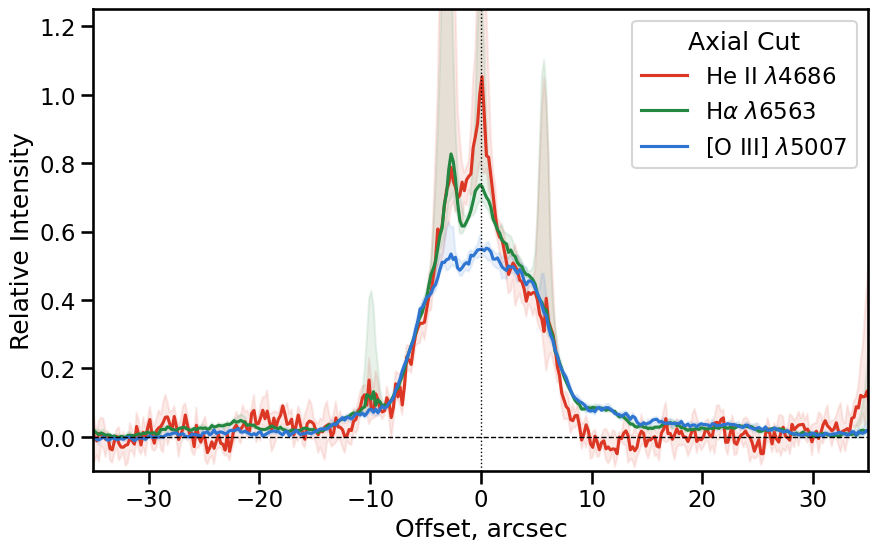

In [211]:
with sns.husl_palette(l=0.5, h=0.04, n_colors=3):
    fig, ax = plt.subplots(figsize=(10, 6))
    for _id in _imrot:
        line, = ax.plot(x, _median_p[_id] - bg_p[_id], label=_label[_id])
        ax.fill_between(
            x, _q1_p[_id] - bg_p[_id], _q3_p[_id] - bg_p[_id],
            alpha=0.1,
            color=line.get_color(),
        )
    ax.axhline(0.0, color="k", linestyle="dashed", lw=1)
    ax.axvline(0.0, color="k", linestyle="dotted", lw=1)
    ax.set_xlim(-35, 35)
    ax.set_ylim(-0.1, 1.25)
    ax.set_xlabel("Offset, arcsec")
    ax.set_ylabel("Relative Intensity")
    ax.legend(title="Axial Cut")

In [212]:
figfile = "nordic-pn-ou5-polar-profile-median.pdf"
fig.savefig(figfile, bbox_inches="tight")
fig.savefig(figfile.replace(".pdf", ".jpg"), bbox_inches="tight")

#### Repeat for no-star images

In [205]:
# Use the same order as RGB image to get consistent colors
_fixrot = {
    "heii": heii_fixrot,
    "ha": ha_fixrot, 
    "oiii": oiii_fixrot, 
}
_mean_fix = {
    _id: np.mean(_fixrot[_id][slit_slice, :], axis=0) / _norm[_id]
    for _id in _imrot
} 
_median_fix = {
    _id: np.median(_fixrot[_id][slit_slice, :], axis=0) / _norm[_id]
    for _id in _imrot
} 
_std_fix = {
    _id: np.std(_fixrot[_id][slit_slice, :], axis=0) / _norm[_id]
    for _id in _imrot
} 
_q1_fix = {
    _id: np.percentile(_fixrot[_id][slit_slice, :], 25, axis=0) / _norm[_id]
    for _id in _imrot
} 
_p10_fix = {
    _id: np.percentile(_fixrot[_id][slit_slice, :], 10, axis=0) / _norm[_id]
    for _id in _imrot
} 
_q3_fix = {
    _id: np.percentile(_fixrot[_id][slit_slice, :], 75, axis=0) / _norm[_id]
    for _id in _imrot
} 

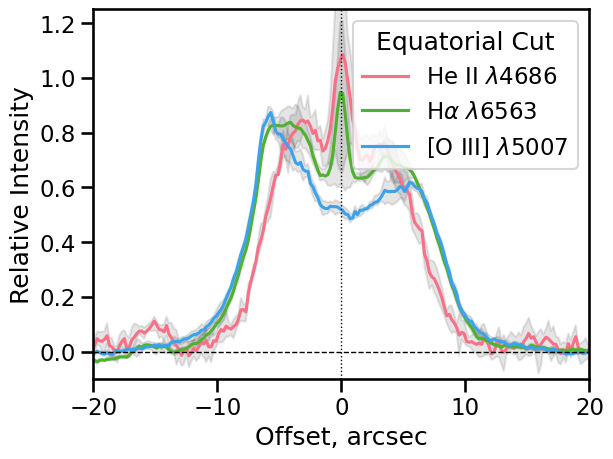

In [206]:
with sns.color_palette("husl", n_colors=3):
    fig, ax = plt.subplots()
    for _id in _imrot:
        line, = ax.plot(x, _mean_fix[_id], label=_label[_id])
        ax.fill_between(
            # x, _mean[_id] - _std[_id], _mean[_id] + _std[_id], 
            x, _q1_fix[_id], _q3_fix[_id],
            alpha=0.1,
            # color=line.get_color(),
            color="k",
        )
    ax.axhline(0.0, color="k", linestyle="dashed", lw=1)
    ax.axvline(0.0, color="k", linestyle="dotted", lw=1)
    
    ax.set_xlim(-20, 20)
    ax.set_ylim(-0.1, 1.25)
    ax.set_xlabel("Offset, arcsec")
    ax.set_ylabel("Relative Intensity")
    ax.legend(title="Equatorial Cut")